# RBI LLM Fine-Tuning

This notebook contains the code for fine-tuning a language model on RBI (Reserve Bank of India) banking regulations and circulars. The model will be trained to answer questions related to Indian banking regulations.

## Setup and Imports

Importing necessary libraries and setting up environment variables.

In [ ]:
# !pip install transformers hf_transfer datasets peft matplotlib bitsandbytes accelerate tensorboard

In [ ]:
# Expose 6006 for tensorboard

In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    
    # Add bfloat16 information
    bf16_supported = torch.cuda.is_bf16_supported()
    print(f"BFloat16 Supported: {bf16_supported}")
    
    # Additional compute capability analysis for bf16
    compute_cap = torch.cuda.get_device_capability(0)
    compute_version = compute_cap[0] + compute_cap[1] * 0.1
    native_bf16 = compute_version >= 8.0
    print(f"Compute Capability: {compute_version}")
    print(f"Native BF16 Support (>=8.0): {native_bf16}")
    
    # Show which precision will be used
    will_use_bf16 = bf16_supported and native_bf16
    print(f"Will Use: {'BF16' if will_use_bf16 else 'FP16'}")
    
else:
    print("CUDA not available - will use FP16 for CPU training")

PyTorch Version: 2.7.1+cu126
CUDA Available: True
CUDA Version: 12.6
cuDNN Version: 90501
GPU Name: NVIDIA GeForce RTX 4090
GPU Capability: (8, 9)
BFloat16 Supported: True
Compute Capability: 8.9
Native BF16 Support (>=8.0): True
Will Use: BF16


In [3]:
PARA = 3
MODEL_NAME = f"Qwen/Qwen2.5-{PARA}B-Instruct"
MODEL_PATH = "./Models"
MODEL_OUTPUT_DIR = f"./Models/Qwen2.5-{PARA}B-Instruct-RBI-QA"
DATASET_NAME = "Vishva007/RBI-Circular-QA-Dataset"
MODEL_ADOPTOR_REPO_ID = f"Vishva007/Qwen2.5-{PARA}B-Instruct-RBI-QA-Adoptor"
SEED = 42# type: ignore

In [4]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True,cache_dir=MODEL_PATH)
if not tokenizer.pad_token:
    print("Pad token is missing, setting it to EOS token.")
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token if it's missing
tokenizer.padding_side = "left"  # IMPORTANT: Set padding_side to 'left' BEFORE tokenizing
print(tokenizer.pad_token)
print(tokenizer.eos_token)

<|endoftext|>
<|im_end|>


## Dataset Preparation

Loading and preparing the dataset containing RBI circulars and question-answer pairs.

In [6]:
dataset = load_dataset(DATASET_NAME, split="train") # type: ignore
print(f"Dataset loaded with {len(dataset)} samples.") # type: ignore
print(dataset)

Dataset loaded with 12000 samples.
Dataset({
    features: ['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics', 'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 'rephrased_question', 'rephrased_answer'],
    num_rows: 12000
})


In [7]:
sys_prompt = """
You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
"""

def format_data(sample):
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": sample["question"]},
        {"role": "assistant", "content": sample["answer"]}
    ]
    # apply_chat_template will convert the list of messages into a single string
    # for the model input, adding control tokens like <s> and </s> if the model
    # supports them. `tokenize=False` ensures it returns a string, not token IDs.
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    return {"text": formatted_prompt}

In [8]:
dataset = dataset.map(format_data).filter(lambda x: x is not None and x["text"] is not None)

In [9]:
print(dataset[5]['text'])

<|im_start|>system

You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
<|im_end|>
<|im_start|>user
What was the Reserve Bank of India's policy regarding the delayed submission of regulatory returns in light of the COVID-19 pandemic, and which types of returns were excluded from this policy?<|im_end|>
<|im_start|>assistant
Due to disruptions caused by the COVID-19 pandemic, the Reserve Bank of India allowed regulated entities to submit regulatory returns to the Department of Regulation with a delay of up to 30 days from the original due date. However, this extension did not apply to statutory returns, such as those prescribed under the Banking Regulation Act, the RBI Act, or any other relevant legislation.<|im_end|>



In [10]:
def tokenize_function(examples):
    # Tokenize the texts with padding and truncation
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


In [11]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics',
'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 
'rephrased_question', 'rephrased_answer','text'],
)


In [12]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.15, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [13]:
print(f"Formatted dataset with {len(dataset)} samples.")
print(dataset[0])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Formatted dataset with 12000 samples.
{'document': 'RBI_2019-2020_228DOR.BP.BC.No.68_21.04.018_2019-20_2020-04-30', 'filename': 'RBI_2019-2020_228DOR.BP.BC.No.68_21.04.018_2019-20_2020-04-30_text_part1.txt', 'model_name': 'models/gemini-2.0-flash', 'regulation_area': 'Regulation of Banks and Financial Institutions', 'applicable_to': 'All Scheduled Commercial Banks, Payments Banks, Local Area Banks, All India Financial Institutions, All Co-operative Banks', 'issued_on': '2020-04-29', 'key_topics': ['Extension of timelines for regulatory returns', 'Submission of regulatory returns', 'COVID-19 pandemic related relaxations', 'Statutory returns'], 'chunks_text': '![](_page_0_Picture_0.jpeg)\n\n## भारतीय �रजवर्ब�क  **RESERVE BANK OF INDIA www.rbi.org.in**\n\nRBI/2019-20/228 DOR.BP.BC.No.68/21.04.018/2019-20 April 29, 2020\n\nAll Scheduled Commercial Banks (including RRBs and Small Finance Banks), Payments Banks and Local Area Banks, All India Financial Institutions, All Co-operative Banks,\n

## Model Configuration

Configuring the model architecture and tokenizer for fine-tuning.

In [14]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
    cache_dir=MODEL_PATH,
    quantization_config=quantization_config
)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), 

## Training Configuration

Setting up the training parameters and callbacks for model fine-tuning.

In [16]:
model = prepare_model_for_kbit_training(model)

In [17]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    use_rslora=True,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj","k_proj","v_proj","o_proj",
        # "gate_proj","up_proj","down_proj",
    ],
)

In [18]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 14,745,600 || all params: 3,100,684,288 || trainable%: 0.4756


In [19]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Set to False for causal LM (not masked LM)
    return_tensors="pt"
)

## Learning rates

For a 1B model: 0.0002 : 2e-4

For a 3B model: 0.0001 : 1e-4

For an 8B model: 0.00002 : 2e-5

For a 30B model: 0.000005 : 5e-6


In [20]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    
    num_train_epochs=2, 
    per_device_train_batch_size=12,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=12, 
    eval_accumulation_steps=2,
    
    # max_steps=200,
    learning_rate=2e-4,              # Slightly higher LR for rsLoRA
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    
    eval_strategy="steps",
    eval_steps=400,  
    save_strategy="steps",
    save_steps=400,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    push_to_hub=False,
    remove_unused_columns=False,
    
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard",
    
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataloader_pin_memory=False,    # Disable pin memory to save GPU memory
    dataloader_num_workers=0,       # Use single worker to save memory
    max_grad_norm=1.0,              # Add gradient clipping
    group_by_length=False,          # Disable to save memory
    length_column_name=None, 
)

### Tensorboard 

pip install tensorboard

cd ../workspace

tensorboard --logdir ./logs --host 0.0.0.0 --port 6006 --reload_interval 5

https://[pod_id]-6006.proxy.runpod.net/

In [21]:

# 7. Initialize the Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [22]:
train_result = trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss,Validation Loss
400,0.825600,0.810126
800,0.635000,0.723693


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

In [23]:
model.save_pretrained(MODEL_OUTPUT_DIR) # type: ignore

## Model Evaluation

Evaluating the fine-tuned model's performance.

In [24]:
train_history = train_result.metrics
eval_history = trainer.evaluate()

In [25]:
final_eval_loss = eval_history.get("eval_loss")

if final_eval_loss is not None:
    final_perplexity = torch.exp(torch.tensor(final_eval_loss)).item()
    print(f"Final Evaluation Loss: {final_eval_loss:.4f}")
    print(f"Final Perplexity: {final_perplexity:.2f}")


Final Evaluation Loss: 0.7237
Final Perplexity: 2.06


Loss plot saved to ./loss_plot.png


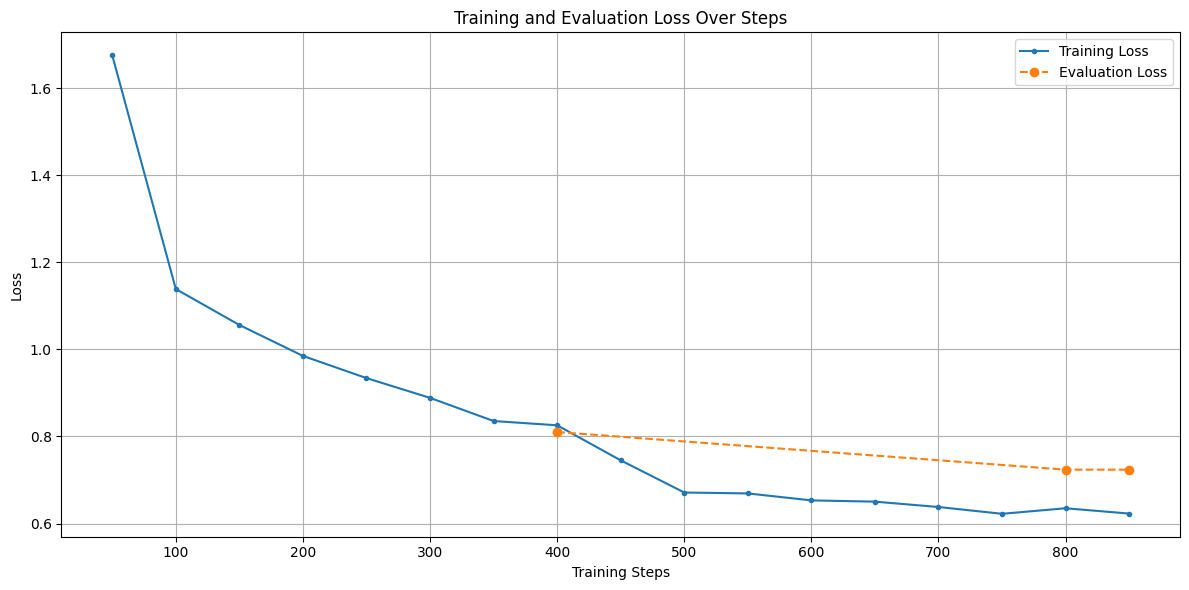

In [26]:
# --- 11. Extracting Metrics from log_history for Plotting ---
train_losses = []
eval_losses = []
eval_steps = [] # Store steps where evaluation occurred

# Iterate through the trainer's log_history
for log in trainer.state.log_history:
    # Training loss is logged at 'logging_steps' intervals
    if "loss" in log and "learning_rate" in log: # Check if it's a training step log
        train_losses.append({"step": log["step"], "loss": log["loss"]})
    # Evaluation loss is logged at 'eval_steps' intervals
    if "eval_loss" in log:
        eval_losses.append({"step": log["step"], "loss": log["eval_loss"]})

# Prepare data for plotting
train_steps_plot = [entry["step"] for entry in train_losses]
train_values_plot = [entry["loss"] for entry in train_losses]

eval_steps_plot = [entry["step"] for entry in eval_losses]
eval_values_plot = [entry["loss"] for entry in eval_losses]

# --- 12. Plotting the Training and Evaluation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(train_steps_plot, train_values_plot, label="Training Loss", marker='.')
plt.plot(eval_steps_plot, eval_values_plot, label="Evaluation Loss", marker='o', linestyle='--')

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plot_path = os.path.join("./", "loss_plot.png")
plt.savefig(plot_path)
print(f"Loss plot saved to {plot_path}")
plt.show()

In [27]:
from huggingface_hub import notebook_login

notebook_login()

In [28]:

model.push_to_hub(MODEL_ADOPTOR_REPO_ID)  # type: ignore

tokenizer.push_to_hub(MODEL_ADOPTOR_REPO_ID)

print(f"LoRA adapters pushed to https://huggingface.co/{MODEL_ADOPTOR_REPO_ID}")

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

LoRA adapters pushed to https://huggingface.co/Vishva007/Qwen2.5-3B-Instruct-RBI-QA-Adoptor
